In [1]:
import argparse
import pickle
from functools import partial

import haiku as hk
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import optax
import tensorflow as tf
import tensorflow_probability as tfp
from chainconsumer import ChainConsumer
from haiku._src.nets.resnet import ResNet18
from jax.lib import xla_bridge
from jax_lensing.model import make_full_field_model
from numpyro import distributions as dist
from numpyro.handlers import condition, seed, trace
from sbi_lens.normflow.models import AffineCoupling, ConditionalRealNVP
from sbi_lens.normflow.train_model import TrainModel
from tqdm import tqdm

print(xla_bridge.get_backend().platform)

tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


gpu


In [2]:
print("######## LPT MODEL ########")
# setting
sigma_e = 0.26
ngal   = 6
a,b,z0 = 22,11.5,0.75
zz     = jnp.linspace(0,1.2,1000)
nz     = zz**a*jnp.exp(-((zz / z0) ** b))
nz     = nz/jnp.sum(nz)/(zz[1]-zz[0])

nz_shear = [jc.redshift.kde_nz(zz,nz,bw=0.01, zmax=2.5, gals_per_arcmin2=ngal) for i in range(1)]

nb_bins = nbins    = len(nz_shear)


Omega_b = 0.049
Omega_c = 0.315 - Omega_b
sigma_8 = 0.8
h       = 0.677
n_s     = 0.9624
w0      = -1
cosmo   = jc.Cosmology(Omega_c = Omega_c,
                       sigma8  = sigma_8,
                       Omega_b = Omega_b,
                       Omega_k = 0.,
                       h   = h,
                       n_s = n_s,
                       w0  = w0,
                       wa  = 0.)

# Specify the size and resolution of the patch to simulate
field_size = 5.17   # transverse size in degrees
field_npix = 60   # number of pixels per side
print("Pixel size in arcmin: ", field_size * 60 / field_npix)


# Now, let's build a full field model
import numpyro
import numpyro.distributions as dist
from jax_lensing.model import make_full_field_model

# High resolution settings
# Note: this low resolution on the los impacts a tiny bit the cross-correlation signal,
# but it's probably worth it in terms of speed gains
box_size  = [400., 400., 4000.]     # In Mpc/h
box_shape = [300,  300,  256]       # Number of voxels/particles per side

# Generate the forward model given these survey settings
lensing_model = jax.jit(make_full_field_model( field_size=field_size,
                                            field_npix=field_npix,
                                            box_size=box_size,
                                            box_shape=box_shape))
# Define the probabilistic model
def model():
  """
  This function defines the top-level forward model for our observations
  """
  # Sampling initial conditions
  initial_conditions = numpyro.sample('initial_conditions', dist.Normal(jnp.zeros(box_shape),
                                                                        jnp.ones(box_shape)))

  Omega_b = 0.049
  Omega_c = numpyro.sample("omega_c", dist.Uniform(0.1, 0.7))
  sigma_8 = numpyro.sample("sigma_8", dist.Uniform(0.5, 1.6))
  h       = 0.677
  n_s     = 0.9624
  w0      = -1
  cosmo   = jc.Cosmology(Omega_c = Omega_c,
                         sigma8  = sigma_8,
                         Omega_b = Omega_b,
                         Omega_k = 0.,
                         h   = h,
                         n_s = n_s,
                         w0  = w0,
                         wa  = 0.)

  # Generate random convergence maps
  convergence_maps, _ = lensing_model(cosmo, nz_shear, initial_conditions)


  # Apply noise to the maps (this defines the likelihood)
  observed_maps = [numpyro.sample('kappa_%d'%i,
                                  dist.Normal(k, sigma_e/jnp.sqrt(nz_shear[i].gals_per_arcmin2*(field_size*60/field_npix)**2)))
                   for i,k in enumerate(convergence_maps)]

  return observed_maps

######## LPT MODEL ########
Pixel size in arcmin:  5.17


In [3]:
print("######## FIDUCIAL MODEL ########")

model_tracer = numpyro.handlers.trace(numpyro.handlers.seed(model, jax.random.PRNGKey(1234)))
model_trace = model_tracer.get_trace()

from functools import partial

observed_map = jnp.stack([model_trace["kappa_%d" % i]["value"] for i in range(1)], axis=-1)

######## FIDUCIAL MODEL ########


/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/linkhome/rech/genkqu01/uf

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['trace', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


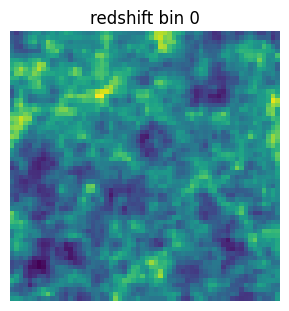

In [4]:
%pylab inline
figure(figsize=[16,4])
for i in range(1):
    subplot(1,4,i+1)
    title('redshift bin %d'%i)
    imshow(model_trace['kappa_%d'%i]['fn'].mean)
    axis('off')

In [ ]:
print("######## DATA GENERATION ########")


@jax.jit
@jax.vmap
def get_data(key):
    seeded_model = numpyro.handlers.seed(model, key)
    model_trace = numpyro.handlers.trace(seeded_model).get_trace()
    kmap = jnp.stack(
        [
            model_trace["kappa_0"]["value"],
        ],
        axis=-1,
    ).astype("float32")
    theta = jnp.stack([model_trace["omega_c"]["value"], model_trace["sigma_8"]["value"]])

    return theta, kmap


# training dataset
params_train = []
maps_train = []
masterkey = jax.random.PRNGKey(42)
bs = 5

for i in tqdm(range(20_000)):
    key, masterkey = jax.random.split(masterkey)
    params, kmap = get_data(jax.random.split(key, bs))
    params_train.append(params)
    maps_train.append(kmap)

params_train = np.stack(params_train).reshape([-1, 2])
maps_train = np.stack(maps_train).reshape([-1, field_npix, field_npix, nbins])
dataset_train = {"theta": params_train, "maps": maps_train[:,:,:,0]}

del maps_train, params_train

# test dataset
params_test = []
maps_test = []
masterkey = jax.random.PRNGKey(20)
bs = 5

for i in tqdm(range(1000)):
    key, masterkey = jax.random.split(masterkey)
    params, kmap = get_data(jax.random.split(key, bs))
    params_test.append(params)
    maps_test.append(kmap)

params_test = np.stack(params_test).reshape([-1, 2])
maps_test = np.stack(maps_test).reshape([-1, field_npix, field_npix, nbins])
dataset_test = {"theta": params_test, "maps": maps_test[:,:,:,0]}

del maps_test, params_test

######## DATA GENERATION ########


 54%|█████▍    | 10886/20000 [59:01<49:12,  3.09it/s] 

In [22]:
print("######## CREATE COMPRESSOR ########")
dim = 2

# nf
bijector_layers_compressor = [128] * 2

bijector_compressor = partial(
    AffineCoupling, layers=bijector_layers_compressor, activation=jax.nn.silu
)

NF_compressor = partial(ConditionalRealNVP, n_layers=4, bijector_fn=bijector_compressor)


class Flow_nd_Compressor(hk.Module):
    def __call__(self, y):
        nvp = NF_compressor(dim)(y)
        return nvp


nf = hk.without_apply_rng(
    hk.transform(lambda theta, y: Flow_nd_Compressor()(y).log_prob(theta).squeeze())
)

#compressor
class CompressorCNN2D(hk.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim

    def __call__(self, x):
        net_x = hk.Conv2D(32, 3, 2)(x) 
        net_x = jax.nn.leaky_relu(net_x)
        net_x = hk.Conv2D(64, 3, 2)(net_x) 
        net_x = jax.nn.leaky_relu(net_x)
        net_x = hk.Conv2D(128, 3, 2)(net_x)
        net_x = jax.nn.leaky_relu(net_x)
        net_x = hk.AvgPool(16,8,'SAME')(net_x) 
        net_x = hk.Flatten()(net_x)

        net_x = hk.Linear(2)(net_x)
        
        return net_x.squeeze()
    
compressor = hk.transform_with_state(lambda y: CompressorCNN2D(dim)(y))
compressor_eval = hk.transform_with_state(lambda y: CompressorCNN2D(dim)(y))

######## CREATE COMPRESSOR ########


In [23]:
print("######## TRAIN ########")

# init compressor
parameters_resnet, opt_state_resnet = compressor.init(
    jax.random.PRNGKey(0), y=0.5 * jnp.ones([1, field_npix, field_npix, nbins])
)
# init nf
params_nf = nf.init(
    jax.random.PRNGKey(0), theta=0.5 * jnp.ones([1, dim]), y=0.5 * jnp.ones([1, dim])
)

parameters_compressor = hk.data_structures.merge(parameters_resnet, params_nf)

del parameters_resnet, params_nf

# define optimizer
total_steps = 70_000
lr_scheduler = optax.piecewise_constant_schedule(
    init_value=0.001,
    boundaries_and_scales={
        int(total_steps * 0.1): 0.7,
        int(total_steps * 0.2): 0.7,
        int(total_steps * 0.3): 0.7,
        int(total_steps * 0.4): 0.7,
        int(total_steps * 0.5): 0.7,
        int(total_steps * 0.6): 0.7,
        int(total_steps * 0.7): 0.7,
        int(total_steps * 0.8): 0.7,
        int(total_steps * 0.9): 0.7,
    },
)

optimizer_c = optax.adam(learning_rate=lr_scheduler)
opt_state_c = optimizer_c.init(parameters_compressor)

model_compressor = TrainModel(
    compressor=compressor,
    nf=nf,
    optimizer=optimizer_c,
    loss_name="train_compressor_vmim",
)

update = jax.jit(model_compressor.update)

batch_size = 128

store_loss = []
loss_train = []
loss_test = []
masterkey = jax.random.PRNGKey(0)
for batch in tqdm(range(total_steps + 1)):
    key, masterkey= jax.random.split(masterkey)
    inds = np.random.randint(0, len(dataset_train["theta"]), batch_size)
    if not jnp.isnan(dataset_train["theta"][inds]).any():
        b_loss, parameters_compressor, opt_state_c, opt_state_resnet = update(
            model_params=parameters_compressor,
            opt_state=opt_state_c,
            theta=dataset_train["theta"][inds],
            x=dataset_train["maps"][inds].reshape([batch_size,field_npix, field_npix, nbins]),#augmentation(dataset_train["maps"][inds], jax.random.split(key, batch_size)).reshape([batch_size,field_npix, field_npix, nbins]),
            state_resnet=opt_state_resnet,
        )

        store_loss.append(b_loss)

        if jnp.isnan(b_loss):
            print("NaN Loss")
            break
            
    if batch % 5_000 == 0:
        # save params
        with open(f"./save_params/params_nd_compressor_batch{batch}.pkl", "wb") as fp:
            pickle.dump(parameters_compressor, fp)

        with open(f"./save_params/opt_state_resnet_batch{batch}.pkl", "wb") as fp:
            pickle.dump(opt_state_resnet, fp)

    inds2 = np.random.randint(0, len(dataset_test["theta"]), batch_size)

    b_loss_test, _, _, _ = update(
        model_params=parameters_compressor,
        opt_state=opt_state_c,
        theta=dataset_test["theta"][inds2],
        x=dataset_test["maps"][inds2].reshape([batch_size,field_npix, field_npix, nbins]),#augmentation(dataset_test["maps"][inds2], jax.random.split(key, batch_size)).reshape([batch_size,field_npix, field_npix, nbins]) ,
        state_resnet=opt_state_resnet,
    )

    loss_train.append(b_loss)
    loss_test.append(b_loss_test)

######## TRAIN ########


100%|██████████| 70001/70001 [07:28<00:00, 155.95it/s]


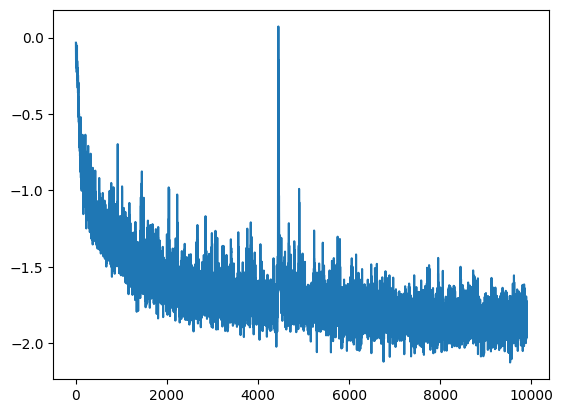

In [24]:
plt.plot(store_loss[100:10000])

Text(0.5, 1.0, 'Batch Loss')

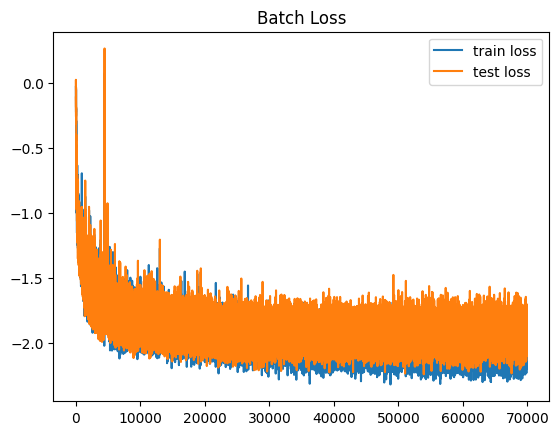

In [25]:
plt.figure()
plt.plot(loss_train[100:], label="train loss")
plt.plot(loss_test[100:], label="test loss")
plt.legend()
plt.title("Batch Loss")

In [27]:
# compress dataset
data_compressed, _ = compressor_eval.apply(
    parameters_compressor, 
    opt_state_resnet, 
    None, 
    dataset_test['maps'].reshape([-1,field_npix, field_npix, nbins]))
    # augmentation(dataset_test['maps'],jax.random.split(jax.random.PRNGKey(707), len(dataset_test['maps']))).reshape([-1,field_npix, field_npix, nbins]))

test_dataset_compressed = {'theta':dataset_test['theta'], 'x':data_compressed}

######## CREATE NDE ########


loss -1.950: 100%|██████████| 100000/100000 [06:34<00:00, 253.71it/s]


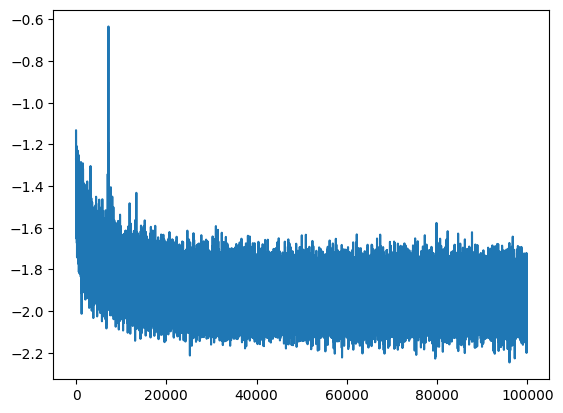

In [28]:
print("######## CREATE NDE ########")
# Create neural density estimator (NDE) to approximate p(theta | y)


dataset = test_dataset_compressed
summary_stat_dim = 2
nb_params_to_infer = 2
batch_size = 128


# Affine bijection used in the RealNVP coupling
bijector_ff = partial(
  AffineCoupling,
  layers=[128] * 2,
  activation=jax.nn.silu
)

# Normalizing Flow with 4 RealNVP coupling layers
NF_ff = partial(
  ConditionalRealNVP,
  n_layers=4,
  bijector_fn=bijector_ff
)


# log probability of the NDE
nf_logp_ff = hk.without_apply_rng(
    hk.transform(
        lambda theta,y : NF_ff(nb_params_to_infer)(y).log_prob(theta).squeeze()
    )
)

# sampling of the NDE
nf_sample_ff = hk.transform(
  lambda y : NF_ff(nb_params_to_infer)(y).sample(100_000, seed=hk.next_rng_key())
)

# negative log likelihood
def loss_nll(params, mu, batch):
    return - jnp.mean(nf_logp_ff.apply(params, mu, batch))

@jax.jit
def update(params, opt_state, mu, batch):
    """Single SGD update step."""
    loss, grads  = jax.value_and_grad(loss_nll)(
        params,
        mu,
        batch,
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

# init nf params
params_ff = nf_logp_ff.init(
    jax.random.PRNGKey(42),
    0.5 * jnp.ones([1, nb_params_to_infer]),
    0.5 * jnp.ones([1, summary_stat_dim])
)

total_steps = 100_000
nb_steps = total_steps - total_steps * 0.2

lr_scheduler = optax.exponential_decay(
        init_value=1e-3,
        transition_steps=nb_steps // 50,
        decay_rate=0.9,
        end_value=1e-5,
)

# define optimizer
optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state_ff = optimizer.init(params_ff)


# training
from tqdm import tqdm

batch_size = 128
batch_loss = []
pbar = tqdm(range(total_steps))

for batch in pbar:
    inds = np.random.randint(0, len(dataset['theta']), batch_size)

    l, params_ff, opt_state_ff = update(
      params_ff,
      opt_state_ff,
      dataset['theta'][inds],
      dataset['x'][inds],
    )
    batch_loss.append(l)
    pbar.set_description(f"loss {l:.3f}")

plt.plot(batch_loss[100:])

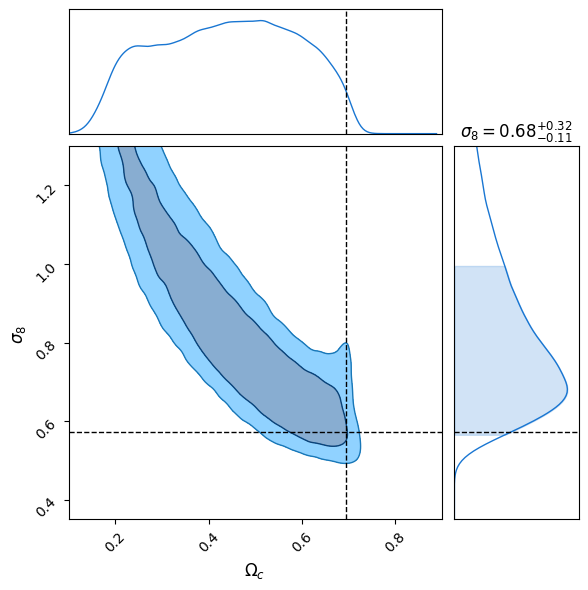

In [29]:
# plot infered params

model_tracer = numpyro.handlers.trace(numpyro.handlers.seed(model, jax.random.PRNGKey(1234)))
model_trace = model_tracer.get_trace()


from chainconsumer import ChainConsumer

observed_map_compressed, _ = compressor_eval.apply(parameters_compressor, opt_state_resnet, None, observed_map.reshape([1,field_npix,field_npix,nbins]))
posterior_ff = nf_sample_ff.apply(
      params_ff,
      rng = jax.random.PRNGKey(43),
      y = observed_map_compressed * jnp.ones([100_000, summary_stat_dim])
)


c = ChainConsumer()


c.add_chain(
    posterior_ff,
    shade_alpha = 0.5,
    name='SBI full-field',
    parameters=['$\Omega_c$','$\sigma_8$']
)


fig = c.plotter.plot(figsize=2.,truth=[model_trace['omega_c']['value'], model_trace['sigma_8']['value']], extents={"$\Omega_c$": (0.1,0.9), "$\sigma_8$": (0.35,1.3)})

In [30]:
from numpyro.handlers import condition, seed, trace
print("######### FIDUCIAL MODEL ##########")

Omega_b = 0.049
Omega_c = 0.315 - Omega_b
sigma_8 = 0.8

# condition the model on a given set of parameters
fiducial_model = condition(
    model, {"omega_c": Omega_c, "sigma_8": sigma_8}
)

# sample a mass map and save corresponding true parameters
model_trace = trace(seed(fiducial_model, jax.random.PRNGKey(1234))).get_trace()

m_data = jnp.stack([model_trace["kappa_%d" % i]["value"] for i in range(1)], axis=-1)

truth = [Omega_c, sigma_8]

######### FIDUCIAL MODEL ##########


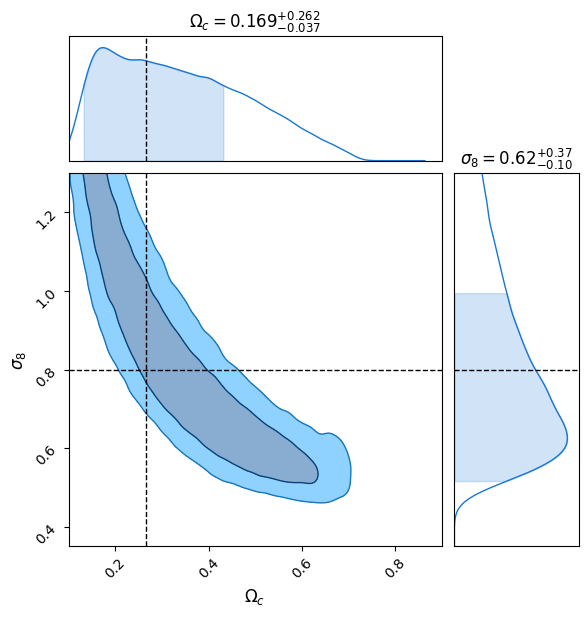

In [31]:
# plot infered params
from chainconsumer import ChainConsumer

observed_map_compressed2, _ = compressor_eval.apply(parameters_compressor, opt_state_resnet, None, m_data.reshape([1,field_npix,field_npix,nbins]))
posterior_ff2 = nf_sample_ff.apply(
      params_ff,
      rng = jax.random.PRNGKey(43),
      y = observed_map_compressed2 * jnp.ones([100_000, summary_stat_dim])
)


c = ChainConsumer()


c.add_chain(
    posterior_ff2,
    shade_alpha = 0.5,
    name='SBI full-field',
    parameters=['$\Omega_c$','$\sigma_8$']
)


fig = c.plotter.plot(figsize=2.,truth=truth, extents={"$\Omega_c$": (0.1,0.9), "$\sigma_8$": (0.35,1.3)})